### Backup 3: Physics-informed Operator Learning in TorchPhysics

We keep the integral operator given by the ODE
\begin{align*}
    \partial_t u(t) &= 5.0f(t) \quad \text{ for } t \in (0, 1), \\
    u(0) &= 0.
\end{align*}
from the previous examples. Still, our goal is to train one network that outputs $u$ for a given $f$. However, we now don't have data set consisting of pairs $(u, f)$. Instead, we use the PINN-idea from the first examples to train our FNO.

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
os.environ["CUDA_VISIBLE_DEVICES"]= str(user % 4)

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from data_gen_integrator import integrator

We load the data as before. The data for $f$ will be used in the training, the data for $u$ only later for validation!

Time discretization: 100
Available data points: 20000
Shape of data: torch.Size([20000, 100, 1])


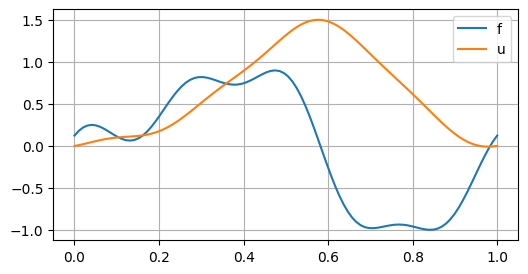

In [8]:
save_path = "/localdata/tomfre/Data_integrator"
input_t = torch.load(f"{save_path}/input_t.pt")
input_f = torch.load(f"{save_path}/input_f.pt")
output_u = torch.load(f"{save_path}/output_u.pt")

delta_t = (input_t[1] - input_t[0]).item()

# step_f = torch.zeros((500, len(input_t), 1))
# t_0_random = torch.rand((500, 1, 1))
# step_f[:] = (t_0_random[:] <= input_t)
# step_u = integrator(input_t, step_f)

# input_f = torch.cat((step_f, input_f), dim=0)
# output_u = torch.cat((step_u, output_u), dim=0)

print("Time discretization:", len(input_t))
print("Available data points:", len(input_f))
print("Shape of data:", input_f.shape)

example_idx = 0
plt.figure(0, figsize=(6, 3))
plt.plot(input_t, input_f[example_idx])
plt.plot(input_t, output_u[example_idx])
plt.grid()
leg = plt.legend(["f", "u"])

The spaces are the same as in the previous example.

In [9]:
T = tp.spaces.R1("t")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

# TODO: Add the correct function spaces
fn_space_F = tp.spaces.FunctionSpace(T, F) 
fn_space_U = tp.spaces.FunctionSpace(T, U)

Given that we now use physics-informed loss terms, we also need to define our domain as we did in the first two examples.

We still select 80% from our available functions $f$ for the training process.

In [10]:
# Split data into training and testing:
total_data = len(input_f)

# TODO: select 80% of total_data and set train_f accordingly.
train_N = int(0.8*total_data)

train_f = input_f[:train_N]
# Note: no train_u here, since we assume this data is not available!

test_f = input_f[train_N:]
test_u = output_u[train_N:] # only u for testing!

# Define FunctionSet (DataSet)
data_functionset_input = tp.domains.DataFunctionSet(fn_space_F, train_f)

In [11]:
# TODO: Complete the FunctionSampler, which should return 6000 samples of f when called.
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(6000, data_functionset_input)

Next, we create an FNO that inputs $f$ and outputs $u$. 

In [12]:
# TODO: Set the correct input and output space, and choose two fourier layers
model = tp.models.FNO(F, U, 2)

As for the PINN approach, we now have to create two conditions that implement our problem.
Starting with the ODE $\partial_t u - 5.0 f = 0$.

As for the *PINNCondition*, we have the *PIDeepONetCondition* that handles the implementation internally. We only have to finish the residual function.

In [13]:
# TODO: Finish the residual function.
# Given that the output of the FNO is already defined on a grid with step size delta_t, 
# We use here a discrete gradient given by a difference quotient.
def ode_residual(u, f):
    return tp.utils.discrete_grad_on_grid(u, delta_t) - 5.0*f

ode_cond = tp.conditions.PIOperatorCondition(module=model, 
                                             input_function_sampler=functionsampler_input, 
                                             residual_fn=ode_residual)

Next is the initial condition $u(0)=0$.

In [14]:
def initial_residual(u):
    return u[:, 0]

# TODO: Add the correct arguments to the condition. Set the weight to 100
initial_cond = tp.conditions.PIOperatorCondition(module=model, 
                                             input_function_sampler=functionsampler_input, 
                                             residual_fn=initial_residual, 
                                             weight=100.0)

Next, we start the training:

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.002,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 2500, "gamma":0.2})
solver = tp.solver.Solver([ode_cond, initial_cond], optimizer_setting=optim)

from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme


trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=10000, 
                    logger=False, 
                    callbacks=[RichProgressBar(theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                    enable_checkpointing=False)

trainer.fit(solver)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:256: Found unsupported keys in the lr scheduler dict: {'gamma', 'step_size'}. HINT: remove them from the output of `configure_optimizers`.

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.2 K 
1 | val_conditions   | ModuleList | 0     
-------------------------

Epoch 0: 100%|██████████| 10000/10000 [03:40<00:00, 45.32it/s, train/loss=0.0391]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [03:40<00:00, 45.32it/s, train/loss=0.0391]


Let us check the perfomance on the unseen testing data:

In [16]:
model_output = model(tp.spaces.Points(test_f, F)).as_tensor.detach()
rel_error = torch.max(torch.abs(model_output - test_u)) / torch.max(torch.abs(test_u))
print(f"Relative error on test data: {rel_error*100} %")

Relative error on test data: 1.2584675550460815 %


Example plot:


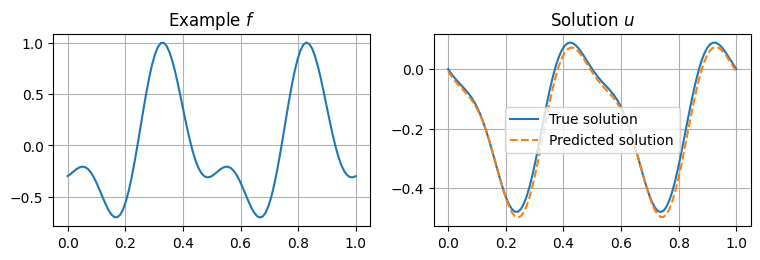

In [17]:
plot_idx = 340

print("Example plot:")
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(input_t, test_f[plot_idx])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(input_t, test_u[plot_idx])
axarr[1].plot(input_t, model_output[plot_idx], linestyle="--")
axarr[1].title.set_text(r"Solution $u$")
axarr[1].grid()
leg = axarr[1].legend(["True solution", "Predicted solution"])

We can now ask how well the model performs on data not included in the data set.
The trainings consisting of oscillating functions and polynomials. So let us check how well the model performs on step functions. Choose a $t_0 \in (0, 1)$ and define 
\begin{equation}
    f(t)  = \begin{cases}
            1 \quad &\text{if } t \geq t_0, \\
            0 \quad &\text{if } t < t_0.
        \end{cases}
\end{equation}

Test:


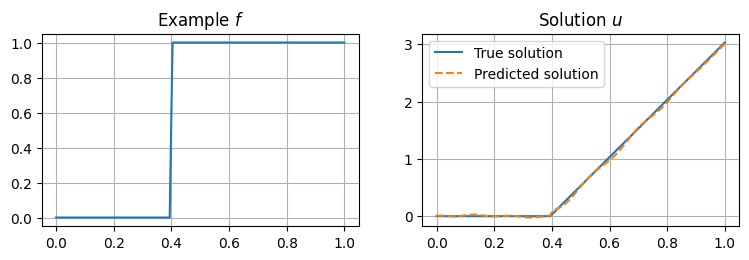

In [18]:
new_f = torch.zeros((1, len(input_t), 1))

#####################################################
# TODO: Here implement your function:
t_0 = 0.4
new_f[0] = (t_0 <= input_t)


#####################################################
expected_u = integrator(input_t, new_f)
model_output = model(tp.spaces.Points(new_f, F)).as_tensor.detach()
print("Test:")
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(input_t, new_f[0])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(input_t, expected_u[0])
axarr[1].plot(input_t, model_output[0], linestyle="--")
axarr[1].title.set_text(r"Solution $u$")
axarr[1].grid()
leg = axarr[1].legend(["True solution", "Predicted solution"])

The performance should be not so good. But we can maybe add some example functions to our train set and hope that this improves the result!
The following code needs to be copied in the second cell, after we load the data, to add some steps functions to our training set. Then run the notebook again and see if this improves the result.

In [19]:
step_f = torch.zeros((500, len(input_t), 1))
t_0_random = torch.rand((500, 1, 1))
step_f[:] = (t_0_random[:] <= input_t)
step_u = integrator(input_t, step_f)

input_f = torch.cat((step_f, input_f), dim=0)
output_u = torch.cat((step_u, output_u), dim=0)

# TODO: Add the above code to the second cell:
#
# input_t = torch.load(f"{save_path}/input_t.pt")
# input_f = torch.load(f"{save_path}/input_f.pt")
# output_u = torch.load(f"{save_path}/output_u.pt")
#
# <- TODO: Add code here! (in the second cell)